<a href="https://colab.research.google.com/github/rallm/IUST-DL-Fall2025/blob/main/HW2/Practical/Gradient-Perturbations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Applying Gradient Perturbation to Convolutional Neural Networks



This notebook explores techniques for generating adversarial examples in image classification problems. Specifically, it employs gradient-based perturbation attacks that utilize the loss gradient of input images to identify adversarial modifications.

The attacks follow the [Fast Gradient Sign Method (FGSM)](https://arxiv.org/pdf/1412.6572), originally proposed by Goodfellow et al. in 2015.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms.transforms import ToTensor
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt

## Setup


We use MNIST's handwritten digit data.

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch
from torch.utils.data import DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

train_data = datasets.MNIST(
    root = 'data',
    # Hint: Set this boolean flag to specify that you want the training portion of the dataset.
    train = True,
    transform = ToTensor(),
    # Hint: Set this boolean flag to automatically download the data if it's not in the 'root' folder.
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    # Hint: Now, specify that this is the testing portion of the dataset.
    train = False,
    transform = ToTensor()
)

# Hint: Create an iterable to load the training data.
# It should process the data in mini-batches of size 64 and shuffle them at every epoch.
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 63.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.4MB/s]


Next, we construct a basic convolutional neural network (CNN) architecture.

In [5]:
#Defining the CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In the following step, we design a simple architecture for a convolutional neural network (CNN).

In [10]:
def train_model(model, train_dataloader, epochs, optimizer, criterion):

    model.train()
    model.to(device)

    for epoch in range(epochs):
        train_loss_accumulate = 0

        for (data, target) in train_dataloader:
            data = data.to(device)
            target = target.to(device)

            # Hint: Before calculating new gradients, you must clear the ones from the previous step.
            optimizer.zero_grad()

            output = model(data)
            loss = criterion(output, target)

            # Hint: Compute the gradient of the loss with respect to all model parameters. This is the backpropagation step.
            loss.backward()

            # Hint: Update the model's weights using the gradients computed in the previous step.
            optimizer.step()

            train_loss_accumulate += loss.item()

    return model


def evaluate_model(model, dataloader, criterion):
    # Hint: Switch the model to evaluation mode. This is important for layers like Dropout and BatchNorm.
    model.eval()

    model.to(device)
    test_accuracy = 0

    # Hint: Since you are not training, gradient calculations are not needed here.
    # Use a torch context manager to disable gradient computation for efficiency.
    #TODO
    with torch.no_grad(): # replace ____ with the correct context manager
        for (data, target) in dataloader:
            data = data.to(device)
            target = target.to(device)
            probs = model(data)

            # Hint: From the raw model outputs (probs), find the index (the class) with the highest value for each item in the batch.
            labels_pred = torch.argmax(probs, dim =1)

            comp = (labels_pred == target)

            # Hint: Calculate the number of correct predictions in the batch and add it to the total.
            test_accuracy += comp.sum().item()

    # Hint: Compute the average accuracy across all batches.
    # return (test_accuracy / len(dataloader.dataset)).item() # this code has problems
    return test_accuracy / len(dataloader.dataset)

By training this CNN without introducing adversarial examples, we observe that it can reach an impressive test accuracy of about 99% on the relatively simple MNIST dataset.

In [11]:
model = CNN()

# Hint: Choose a loss function suitable for a multi-class classification problem.
criterion = nn.CrossEntropyLoss()

# Hint: Choose an optimization algorithm (e.g., Adam or SGD) and pass the model's parameters to it. Set a learning rate, for example, 0.002.
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Hint: Define how many times the model will iterate over the entire training dataset.
epochs = 2 # a small number for fast running

model = train_model(model, train_dataloader, epochs, optimizer, criterion)

print("accuracy of the trained model on the test data:", evaluate_model(model, test_dataloader, criterion))

accuracy of the trained model on the test data: 0.9907


#Gradient-based adversarial attacks

In [12]:
def attack(model, input, label, criterion, epsilon):
    x = input
    x = x.to(device)

    # Hint: To generate an attack, you need to calculate the gradient with respect to the input data itself, not just the model weights.
    # Enable gradient tracking for the input tensor 'x'.
    x.requires_grad = True

    loss = criterion(model(x), label)

    model.zero_grad()

    # Hint: Calculate the gradients of the loss. This will populate the .grad attribute of the input tensor 'x'.
    loss.backward()

    # here, epsilon denotes the stepsize
    # Hint: Create the perturbation by finding the sign of the gradient of 'x' and scaling it by epsilon.
    perturbation = epsilon * x.grad.sign()

    x_perturbed = x + perturbation

    return x_perturbed #the perturbed vector is called x_perturbed


The function above implements a straightforward adversarial gradient attack applicable to any model. Given a model, an input, its label, a loss function, and a perturbation magnitude ε, we (assuming the model is in evaluation mode so its parameters are not tracked by autograd) compute the loss between the model's prediction and the label, then obtain the gradient of that loss with respect to the input.
By adding a small perturbation in the direction of this gradient (scaled by ε) we produce a new input that maximizes the loss — an adversarial example that may cause the model to misclassify.
As demonstrated below, this technique can drastically reduce test accuracy for the trained model, especially as ε grows.

In [13]:
def test_perturbation_accuracy(model, dataloader, criterion, epsilon):
    model.eval()
    model.to(device)
    adversarial_test_accuracy = 0

    for (data, target) in dataloader:
        data = data.to(device)
        target = target.to(device)

        # Hint: Use the 'attack' function you defined earlier to create a perturbed version of the input 'data'.
        data_perturbed = attack(model, data, target, criterion, epsilon)

        data_perturbed = data_perturbed.to(device)

        # Hint: Pass the 'data_perturbed' through the model to get the model's prediction on the adversarial example.
        probs = model(data_perturbed)

        labels_pred = torch.argmax(probs, dim =1)
        comp = (labels_pred == target)
        adversarial_test_accuracy += torch.sum(comp.float()) / comp.shape[0]

    return (adversarial_test_accuracy/len(dataloader)).item()

# Hint: Test the model's robustness with a small perturbation strength (e.g., 0.05).
epsilon = 0.05
acc = test_perturbation_accuracy(model, test_dataloader, nn.CrossEntropyLoss(), epsilon)
print("(1) Considering the perturbation radius", epsilon,", The model’s test accuracy on the perturbed data is = ", acc, '\n')

# Hint: Test again with a medium perturbation strength (e.g., 0.1).
epsilon = 0.1
acc = test_perturbation_accuracy(model, test_dataloader, nn.CrossEntropyLoss(), epsilon)
print("(2) Considering the perturbation radius", epsilon,", The model’s test accuracy on the perturbed data is = ", acc, '\n')

# Hint: Test with a larger perturbation strength (e.g., 0.2) to see how much the accuracy drops.
epsilon = 0.2
acc = test_perturbation_accuracy(model, test_dataloader, nn.CrossEntropyLoss(), epsilon)
print("(3) Considering the perturbation radius", epsilon,", The model’s test accuracy on the perturbed data is = ", acc)

(1) Considering the perturbation radius 0.05 , The model’s test accuracy on the perturbed data is =  0.8458999991416931 

(2) Considering the perturbation radius 0.1 , The model’s test accuracy on the perturbed data is =  0.4283999800682068 

(3) Considering the perturbation radius 0.2 , The model’s test accuracy on the perturbed data is =  0.04969999939203262


Let's display a selection of the perturbed images to inspect their effects.

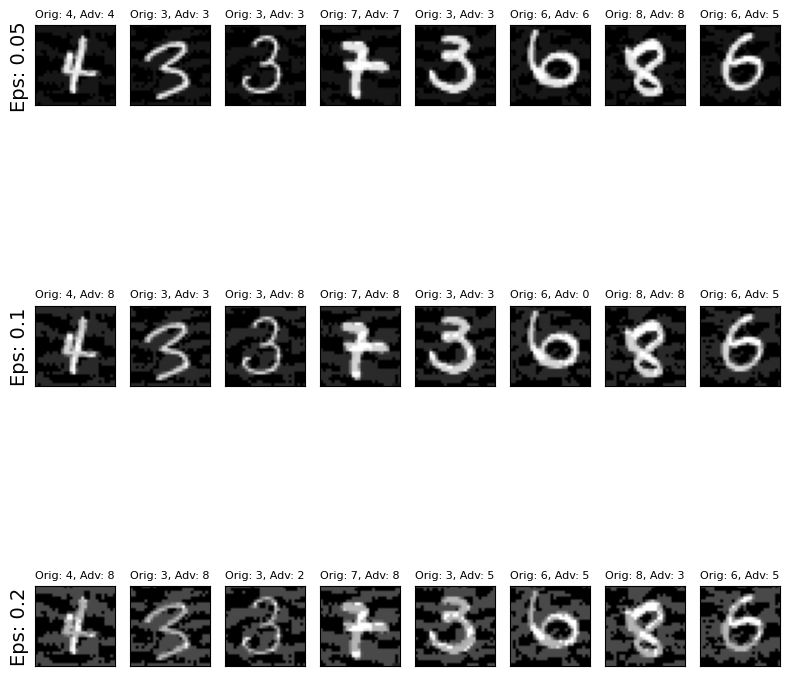

In [16]:
epsilons = [0.05, 0.1, 0.2]
examples = []
accuracies = []


data, target = next(iter(test_dataloader))
data = data.to(device)
target = target.to(device)
# Run test for each epsilon

for eps in epsilons:
    # Hint: Generate an adversarial example using the current epsilon value 'eps'.
    ex = attack(model, data, target, nn.CrossEntropyLoss(), eps)

    probs = model(ex)

    # Hint: Find the model's predicted label from the raw output probabilities 'probs'.
    labels_pred = torch.argmax(probs, dim=1)

    # Hint: Append the final predicted label to the 'accuracies' list to save it.
    accuracies.append(labels_pred)

    # Hint: Also, append the generated adversarial example 'ex' to the 'examples' list for later visualization.
    examples.append(ex)

cnt = 0

plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        # Hint: Arrange the plots in a grid. The number of rows is the number of epsilons,
        # and the number of columns is the number of examples. 'cnt' is the current plot's index.
        plt.subplot(len(epsilons), len(examples[0]), cnt)

        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)

        # Hint: To plot a tensor, you must first process it: move it to the CPU, detach it,
        # remove extra dimensions (squeeze), and convert it to a NumPy array.
        ex = examples[i][j].cpu().detach().squeeze().numpy()

        orig = target[j]
        adv = accuracies[i][j]

        # Hint: Set the title for each subplot to show the original label and what the model predicted for the adversarial example.
        plt.title(f"Orig: {orig}, Adv: {adv}", fontsize=8)

        # Hint: Display the processed image 'ex' using a "gray" colormap.
        plt.imshow(ex, cmap="gray")

plt.tight_layout()
plt.show()

##Building a Robust Model with Adversarial Training


The idea is straightforward: expose the model to adversarial examples during training so it learns these perturbations and becomes robust to them. In every training iteration we perturb the current mini‑batch (using the attack function defined above) and feed the perturbed data to the model. This encourages the model to learn resilience.

For our robustness training we use ε = 0.1 and later evaluate performance under other perturbation magnitudes. A more thorough procedure could randomly sample ε from a continuous range (e.g., [0, 1]) according to some distribution, exposing the model to attacks of varying strength.

In [17]:
def train_model_adversarial(model, train_dataloader, epochs, optimizer, criterion, epsilon):

    model.train()
    model.to(device)

    for epoch in range(epochs):
        train_loss_accumulate = 0

        for (data, target) in train_dataloader:
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()

            # Hint: First, create a perturbed version of the clean 'data' using the attack function.
            # Crucially, .detach() this new tensor from the current computation graph before using it for training.
            data_perturbed = attack(model, data, target, criterion, epsilon).detach()

            # Hint: Now, get the model's output for the 'data_perturbed', not the original clean data.
            output = model(data_perturbed)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss_accumulate += loss.item()

        print("epoch = ", epoch, " loss = ", train_loss_accumulate/len(train_dataloader))

    return model

cnn_model = CNN()

# Hint: Train a new model using your adversarial training function.
# You need to provide an epsilon to be used for generating attacks during the training process (e.g., 0.1).
Model = train_model_adversarial(cnn_model, train_dataloader, 2, optim.Adam(cnn_model.parameters(), lr = 0.002), nn.CrossEntropyLoss(), 0.1)

print("Test accuracy of the trained model:", evaluate_model(Model, test_dataloader, nn.CrossEntropyLoss()))

epoch =  0  loss =  0.49248498065003965
epoch =  1  loss =  0.24403448828629085
Test accuracy of the trained model: 0.9876



As illustrated below, the model has become significantly more robust, achieving over 90% accuracy for perturbations with ε ≤ 0.1, the value used during training. In contrast, the original model’s accuracy fell to around 50% under the same attacks.

Moreover, even for perturbations larger than those seen during robustness training (ε = 0.2), the new model still performs much better, reaching approximately 75% accuracy compared to only 12% for the original model

In [18]:
epsilon = 0.05
acc = test_perturbation_accuracy(Model, test_dataloader, nn.CrossEntropyLoss(), epsilon)
print("(1) Considering the perturbation radius", epsilon,", The model’s test accuracy on the perturbed data is = ", acc, '\n')

epsilon = 0.1
acc = test_perturbation_accuracy(Model, test_dataloader, nn.CrossEntropyLoss(), epsilon)
print("(2) Considering the perturbation radius", epsilon,", The model’s test accuracy on the perturbed data is = ", acc, '\n')

epsilon = 0.2
acc = test_perturbation_accuracy(Model, test_dataloader, nn.CrossEntropyLoss(), epsilon)
print("(3) Considering the perturbation radius", epsilon,", The model’s test accuracy on the perturbed data is = ", acc)

(1) Considering the perturbation radius 0.05 , The model’s test accuracy on the perturbed data is =  0.9662999510765076 

(2) Considering the perturbation radius 0.1 , The model’s test accuracy on the perturbed data is =  0.9312999844551086 

(3) Considering the perturbation radius 0.2 , The model’s test accuracy on the perturbed data is =  0.7303999662399292
